In [236]:
from music21 import *
import glob
import numpy as np
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.callbacks import History, ModelCheckpoint
from keras.optimizers import RMSprop
from datetime import datetime
import matplotlib.pyplot as plt

In [237]:
#path = 'Pop_Music_Midi'
#path = 'midi_songs'
path = 'villa-lobos'
files = glob.glob('{}/*.mid*'.format(path))

In [238]:
melody_corpus = []
for file in files:
    midi = converter.parse(file)
    notes_to_parse = None

    try: # file has instrument parts
        inst = instrument.partitionByInstrument(midi)
        notes_to_parse = inst.parts[0].recurse() 
    except: # file has notes in a flat structure
        notes_to_parse = midi.flat.notes
    note_repr = ()
    for element in notes_to_parse:
        if isinstance(element, note.Note):
            note_repr = (str(element.pitch),element.quarterLength)
        elif isinstance(element, note.Rest):
            note_repr = (str(0),element.quarterLength)
        elif isinstance(element, chord.Chord):
            note_repr = ('.'.join(str(n) for n in element.normalOrder),element.quarterLength)
        if note_repr != ():
          melody_corpus.append(note_repr)

In [239]:
melody_set = set(melody_corpus)
corpus_size = len(melody_set)
print(corpus_size)

142


In [240]:
notes_indices = {nt: i for i, nt in enumerate(melody_set)}
indices_notes = {i: nt for i, nt in enumerate(melody_set)}

In [241]:
phrase_len = 100
step_size = 1

In [242]:
phrases = []
next_notes = []
for i in range(0, len(melody_corpus) - phrase_len, step_size):
    phrases.append(melody_corpus[i: i + phrase_len])
    next_notes.append(melody_corpus[i + phrase_len])
print('nb sequences:', len(phrases))

nb sequences: 814


In [243]:
# transforma os dados em matrizes binarias
X = np.zeros((len(phrases), phrase_len, corpus_size), dtype=np.bool)
y = np.zeros((len(phrases), corpus_size), dtype=np.bool)
print(X.shape)
print(y.shape)

(814, 100, 142)
(814, 142)


In [244]:
for i, phrase in enumerate(phrases):
    for j, nt in enumerate(phrase):
        X[i, j, notes_indices[nt]] = 1
    y[i, notes_indices[next_notes[i]]] = 1

In [252]:
layer_size=128
batch_size = 128
nb_epoch = 200

In [246]:
model = Sequential()
model.add(LSTM(layer_size, return_sequences=True, input_shape=(phrase_len, corpus_size)))
model.add(Dropout(0.2))
model.add(LSTM(layer_size, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(corpus_size))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 100, 128)          138752    
_________________________________________________________________
dropout_11 (Dropout)         (None, 100, 128)          0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 142)               18318     
_________________________________________________________________
activation_6 (Activation)    (None, 142)               0         
Total params: 288,654
Trainable params: 288,654
Non-trainable params: 0
_________________________________________________________________


In [247]:
#model.load_weights('weights-improvement-09-2.8516.hdf5')

In [248]:
history = History()

In [249]:
# define the checkpoint
filepath="weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [250]:
#model.fit(X, y, epochs=20, batch_size=128, callbacks=callbacks_list)

In [253]:
history = model.fit(X, y, batch_size=batch_size, epochs=nb_epoch, callbacks=callbacks_list)

Epoch 1/200
814/814 [==============================] - 2s - loss: 3.9907 - acc: 0.0811     
Epoch 2/200
814/814 [==============================] - 2s - loss: 3.9525 - acc: 0.0663     
Epoch 3/200
814/814 [==============================] - 2s - loss: 3.8227 - acc: 0.0934     
Epoch 4/200
814/814 [==============================] - 2s - loss: 3.7699 - acc: 0.0762     
Epoch 5/200
814/814 [==============================] - 2s - loss: 3.7233 - acc: 0.0909     
Epoch 6/200
814/814 [==============================] - 2s - loss: 3.6394 - acc: 0.0921     
Epoch 7/200
814/814 [==============================] - 2s - loss: 3.5625 - acc: 0.1007     
Epoch 8/200
814/814 [==============================] - 2s - loss: 3.5243 - acc: 0.0897     
Epoch 9/200
814/814 [==============================] - 2s - loss: 3.4219 - acc: 0.0983     
Epoch 10/200
814/814 [==============================] - 2s - loss: 3.4173 - acc: 0.1032     
Epoch 11/200
814/814 [==============================] - 2s - loss: 3.3942 - acc

814/814 [==============================] - 3s - loss: 2.5560 - acc: 0.2015     
Epoch 32/200
814/814 [==============================] - 3s - loss: 2.4975 - acc: 0.2076     
Epoch 33/200
814/814 [==============================] - 3s - loss: 2.4934 - acc: 0.1941     
Epoch 34/200
814/814 [==============================] - 3s - loss: 2.4946 - acc: 0.1966     
Epoch 35/200
814/814 [==============================] - 3s - loss: 2.4631 - acc: 0.1916     
Epoch 36/200
814/814 [==============================] - 3s - loss: 2.3727 - acc: 0.2359     
Epoch 37/200
814/814 [==============================] - 2s - loss: 2.3405 - acc: 0.2359     
Epoch 38/200
814/814 [==============================] - 2s - loss: 2.3988 - acc: 0.2101     
Epoch 39/200
814/814 [==============================] - 2s - loss: 2.3342 - acc: 0.2285     
Epoch 40/200
814/814 [==============================] - 3s - loss: 2.3041 - acc: 0.2445     
Epoch 41/200
814/814 [==============================] - 3s - loss: 2.3362 - acc: 0.

814/814 [==============================] - 2s - loss: 1.8967 - acc: 0.2973     
Epoch 66/200
814/814 [==============================] - 2s - loss: 1.8123 - acc: 0.3354     
Epoch 67/200
814/814 [==============================] - 2s - loss: 1.8398 - acc: 0.3550     
Epoch 68/200
814/814 [==============================] - 2s - loss: 1.8177 - acc: 0.3550     
Epoch 69/200
814/814 [==============================] - 3s - loss: 1.8626 - acc: 0.3120     
Epoch 70/200
814/814 [==============================] - 3s - loss: 1.7937 - acc: 0.3624     
Epoch 71/200
814/814 [==============================] - 2s - loss: 1.7758 - acc: 0.3452     
Epoch 72/200
814/814 [==============================] - 3s - loss: 1.8018 - acc: 0.3403     
Epoch 73/200
814/814 [==============================] - 3s - loss: 1.7281 - acc: 0.3587     
Epoch 74/200
814/814 [==============================] - 3s - loss: 1.7618 - acc: 0.3329     
Epoch 75/200
814/814 [==============================] - 3s - loss: 1.7085 - acc: 0.

814/814 [==============================] - 3s - loss: 1.4800 - acc: 0.4631     
Epoch 100/200
814/814 [==============================] - 3s - loss: 1.4911 - acc: 0.4251     
Epoch 101/200
814/814 [==============================] - 3s - loss: 1.4182 - acc: 0.4816     
Epoch 102/200
814/814 [==============================] - 3s - loss: 1.3984 - acc: 0.5098     
Epoch 103/200
814/814 [==============================] - 3s - loss: 1.4084 - acc: 0.4963     
Epoch 104/200
814/814 [==============================] - 3s - loss: 1.4854 - acc: 0.4091     
Epoch 105/200
814/814 [==============================] - 3s - loss: 1.4282 - acc: 0.4607     
Epoch 106/200
814/814 [==============================] - 3s - loss: 1.3640 - acc: 0.4914     
Epoch 107/200
814/814 [==============================] - 2s - loss: 1.4209 - acc: 0.4509     
Epoch 108/200
814/814 [==============================] - 2s - loss: 1.3723 - acc: 0.4865     
Epoch 109/200
814/814 [==============================] - 2s - loss: 1.3685

814/814 [==============================] - 2s - loss: 1.1501 - acc: 0.5995     
Epoch 136/200
814/814 [==============================] - 2s - loss: 1.1529 - acc: 0.5909     
Epoch 137/200
814/814 [==============================] - 2s - loss: 1.1666 - acc: 0.5799     
Epoch 138/200
814/814 [==============================] - 2s - loss: 1.1021 - acc: 0.6536     
Epoch 139/200
814/814 [==============================] - 2s - loss: 1.1802 - acc: 0.5541     
Epoch 140/200
814/814 [==============================] - 2s - loss: 1.1288 - acc: 0.6106     
Epoch 141/200
814/814 [==============================] - 2s - loss: 1.1032 - acc: 0.6314     
Epoch 142/200
814/814 [==============================] - 2s - loss: 1.1016 - acc: 0.6143     
Epoch 143/200
814/814 [==============================] - 2s - loss: 1.1341 - acc: 0.5737     
Epoch 144/200
814/814 [==============================] - 2s - loss: 1.1265 - acc: 0.6044     
Epoch 145/200
814/814 [==============================] - 2s - loss: 1.0644

814/814 [==============================] - 2s - loss: 0.9042 - acc: 0.7101     
Epoch 172/200
814/814 [==============================] - 2s - loss: 0.8796 - acc: 0.7408     
Epoch 173/200
814/814 [==============================] - 2s - loss: 0.8836 - acc: 0.7211     
Epoch 174/200
814/814 [==============================] - 2s - loss: 0.9099 - acc: 0.6732     
Epoch 175/200
814/814 [==============================] - 2s - loss: 0.9008 - acc: 0.6843     
Epoch 176/200
814/814 [==============================] - 2s - loss: 0.8556 - acc: 0.7457     
Epoch 177/200
814/814 [==============================] - 2s - loss: 0.8569 - acc: 0.7383     
Epoch 178/200
814/814 [==============================] - 2s - loss: 0.8885 - acc: 0.7101     
Epoch 179/200
814/814 [==============================] - 2s - loss: 0.8431 - acc: 0.7518     
Epoch 180/200
814/814 [==============================] - 2s - loss: 0.8564 - acc: 0.7260     
Epoch 181/200
814/814 [==============================] - 2s - loss: 0.8611

dict_keys(['loss', 'acc'])


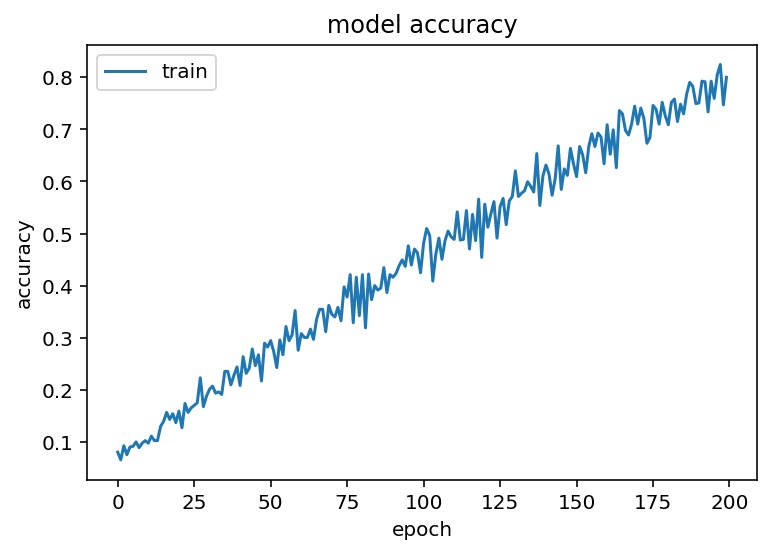

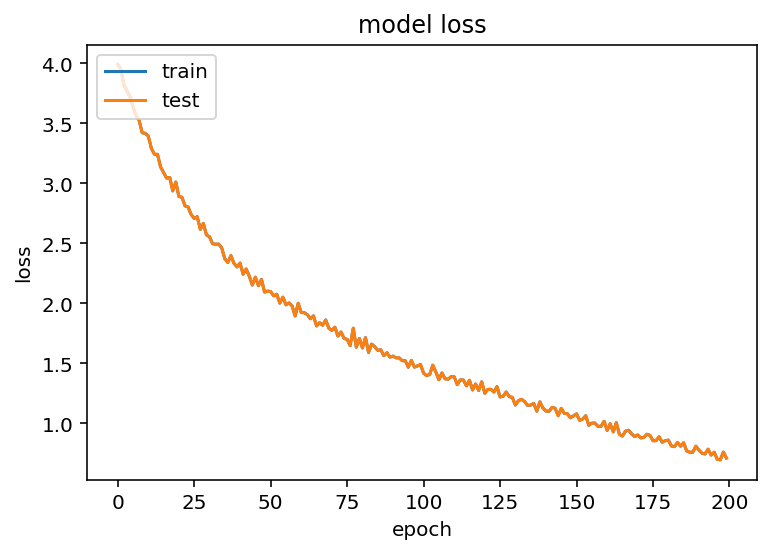

In [254]:

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')


# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

## Gerar Música

In [266]:
seq_len = 100

In [267]:
start = np.random.randint(0, len(phrases)-1)
pattern = phrases[start]
pattern_original = pattern
new_sequence = []
for i in range(seq_len):
    gen_melody_indices = np.zeros((1, phrase_len, len(melody_set)))
    for j, nt in enumerate(pattern):
        gen_melody_indices[0, j, notes_indices[nt]] = 1
    x = gen_melody_indices
    prediction = model.predict(x, verbose=0)[0]
    index = np.argmax(prediction)
    result = indices_notes[index]
    new_sequence.append(result)
    pattern.append(result)
    pattern = pattern[1:len(pattern)]

In [268]:
#transforma os dados para o formato music21

In [269]:
output_notes = []
sc = stream.Score()
for t in new_sequence:
      if t[0] == 0.0:
        r = note.Rest(quarterLength = 0.25)
        sc.append(r)
      elif ('.' in t[0]) or t[0].isdigit():
          notes_in_chord = t[0].split('.')
          #print(notes_in_chord)
          notes = []
          for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            notes.append(new_note)
          new_chord = chord.Chord(notes,quarterLength=t[1])
          #new_chord.offset = offset
          output_notes.append(new_chord)
          sc.append(new_chord)
      else:
          new_note = note.Note(t[0],quarterLength=t[1])
          output_notes.append(new_note)
          
          sc.append(new_note)
midi_stream = stream.Stream(output_notes)
          

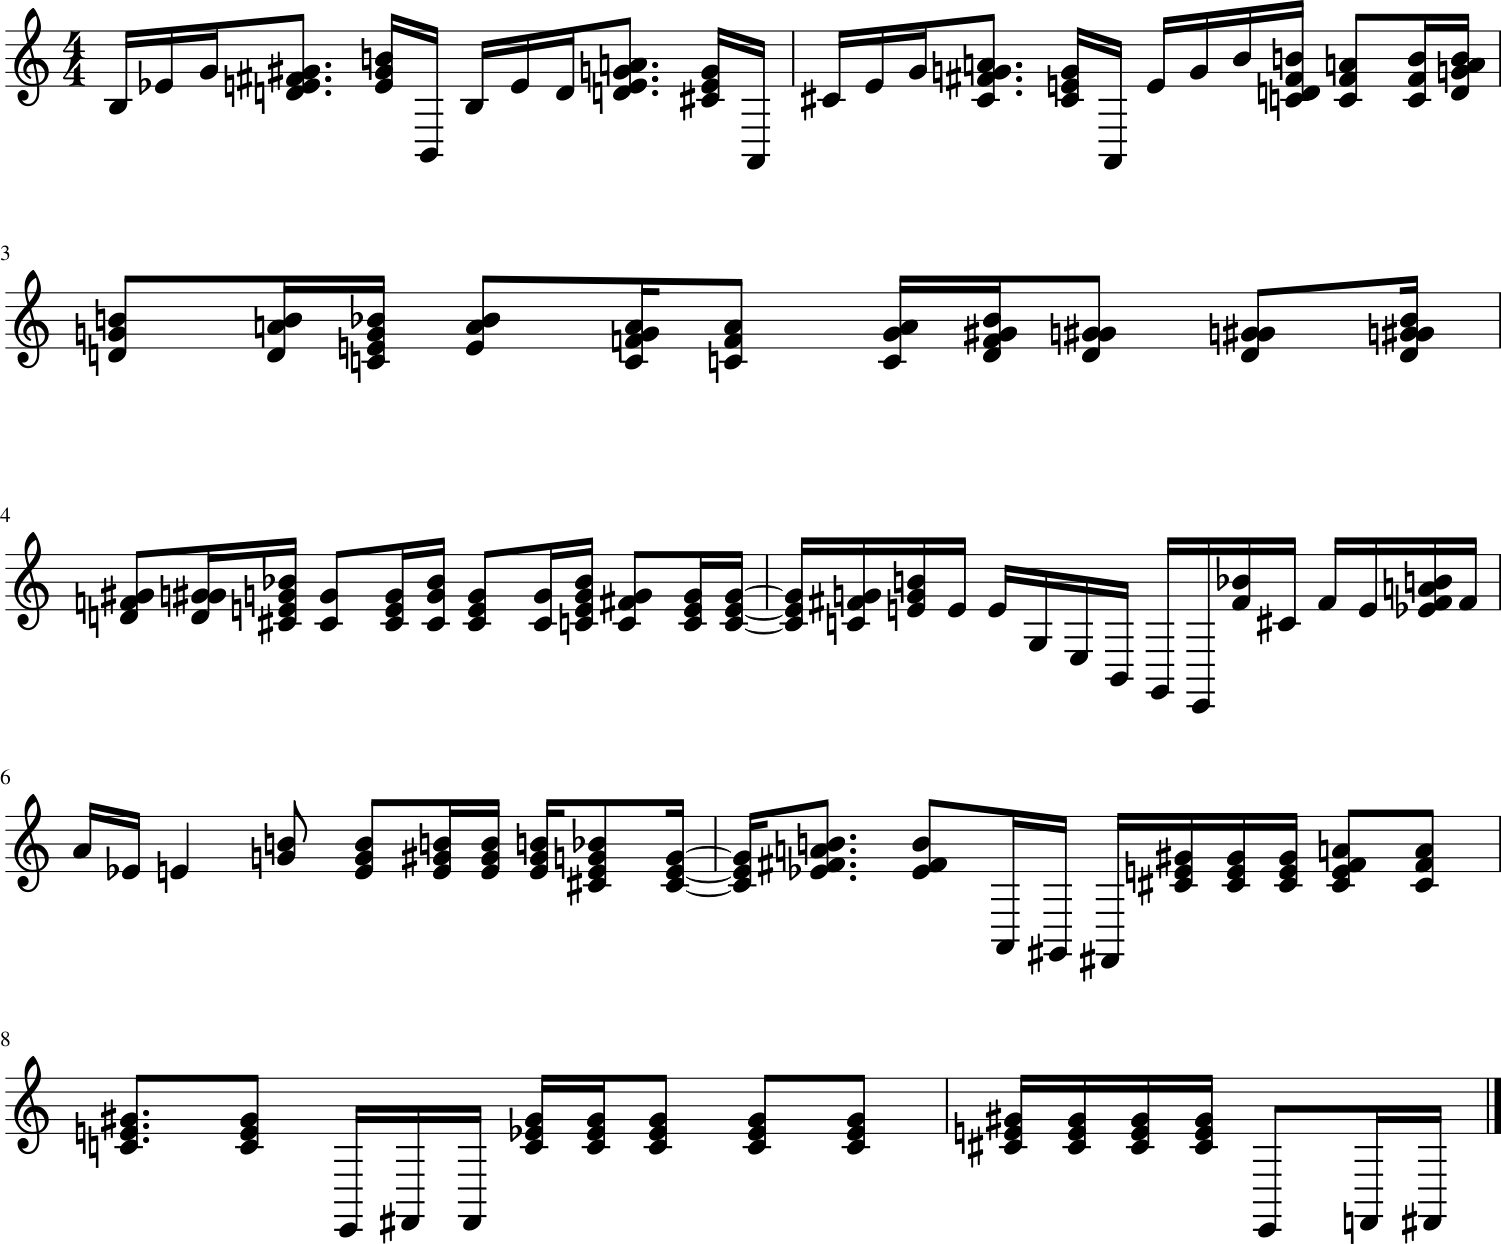

In [270]:
midi_stream.show()

In [271]:
filename = "gerada_" + datetime.now().strftime("%Y%m%d-%H%M%S"+".mid")

In [272]:
from music21 import *
mf = midi.translate.streamToMidiFile(sc)
mf.open(filename, 'wb')
mf.write()
mf.close()

In [273]:
print(filename)

gerada_20180711-233506.mid


In [274]:
new_sequence

[('B3', 0.25),
 ('E-4', 0.25),
 ('G4', 0.25),
 ('2.4.6.8', 0.75),
 ('4.8.11', 0.25),
 ('B2', 0.25),
 ('B3', 0.25),
 ('E4', 0.25),
 ('D4', 0.25),
 ('2.4.7.9', 0.75),
 ('1.4.7', 0.25),
 ('A2', 0.25),
 ('C#4', 0.25),
 ('E4', 0.25),
 ('G4', 0.25),
 ('6.7.9.1', 0.75),
 ('1.4.7', 0.25),
 ('A2', 0.25),
 ('E4', 0.25),
 ('G4', 0.25),
 ('B4', 0.25),
 ('11.0.2.6', 0.25),
 ('6.9.0', 0.5),
 ('6.11.0', 0.25),
 ('7.9.11.2', 0.25),
 ('7.11.2', 0.5),
 ('9.11.2', 0.25),
 ('4.7.10.0', 0.25),
 ('4.9.10', 0.5),
 ('5.7.9.0', 0.25),
 ('5.9.0', 0.5),
 ('7.9.0', 0.25),
 ('2.5.8.10', 0.25),
 ('2.7.8', 0.5),
 ('2.7.8', 0.5),
 ('7.8.10.2', 0.25),
 ('2.5.8', 0.5),
 ('2.7.8', 0.25),
 ('1.4.7.10', 0.25),
 ('1.7', 0.5),
 ('1.4.7', 0.25),
 ('7.10.1', 0.25),
 ('1.4.7', 0.5),
 ('1.7', 0.25),
 ('4.7.10.0', 0.25),
 ('6.7.0', 0.5),
 ('0.4.7', 0.25),
 ('0.4.7', 0.5),
 ('6.7.0', 0.25),
 ('4.7.11', 0.25),
 ('E4', 0.25),
 ('E4', 0.25),
 ('G3', 0.25),
 ('E3', 0.25),
 ('B2', 0.25),
 ('G2', 0.25),
 ('E2', 0.25),
 ('6.10', 0.25),


## PATTERN ORIGINAL

In [275]:
new_sequence = pattern_original
output_notes = []
sc = stream.Score()
for t in new_sequence:
      if t[0] == 0.0:
        r = note.Rest(quarterLength = 0.25)
        sc.append(r)
      elif ('.' in t[0]) or t[0].isdigit():
          notes_in_chord = t[0].split('.')
          #print(notes_in_chord)
          notes = []
          for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            notes.append(new_note)
          new_chord = chord.Chord(notes,quarterLength=t[1])
          #new_chord.offset = offset
          output_notes.append(new_chord)
          sc.append(new_chord)
      else:
          new_note = note.Note(t[0],quarterLength=t[1])
          output_notes.append(new_note)
          
          sc.append(new_note)
midi_stream = stream.Stream(output_notes)
from music21 import *
mf = midi.translate.streamToMidiFile(sc)
mf.open('pattern_original.mid', 'wb')
mf.write()
mf.close()

In [265]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)